# Data visualization for the different parks gathered

In the process of data preprocessing, the bolded out points below is the focus of this notebook.

Plan:

- Transform data
    - Pretend current wind predictions are measurements
    - Transform degrees into cos and sin values

- Divide into parks, and for each park:
    - Overview over NaN values and how to deal with them
    - Autocorrelation over wind speed, wind direction, production
    - How much does the wind speed and wind direction change when the forecast is updated?
    - How is the wind speed and the production correlated?

- Look at data for all parks
    - **Normalize data for all parks (max production at each park is 1)**
    - **Look at correlations between production at the different parks**
    - **Look at correlations again, this time after splitting the data into wind direction quadrant**

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, acf, pacf, plot_pacf

import sys
import os

from satprod.data_handlers.num_data import NumericalDataHandler
from satprod.data_handlers.data_utils import get_columns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

from matplotlib import cycler
colors = cycler('color',
                ['#00C700', '#1F3DFF', 
                 '#F2D42E', '#000066', '#C4000D', '#FF5924', '#4FFF57', '#FFA6BD',
                 '#FF2459', '#540AFF'])

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [34]:
pd.set_option("display.max_rows", 700, "display.max_columns", 50)

In [35]:
num = NumericalDataHandler()
data = num.read_formatted_data(nan=True)
data = data[[c for c in data.columns if '+' not in c]]

# the no nan data is not available for the test set times, so there is nothing to remove
#split = datetime(2020, 5, 1, 0)
#data = data[data.index < split]

wind = get_columns(data, 'wind')
prod = get_columns(data, 'production')

In [36]:
prod

,production_bess,production_skom,production_vals,production_yvik
time,,,,
2006-01-01 00:00:00,NaN,NaN,NaN,NaN
2006-01-01 01:00:00,NaN,NaN,NaN,NaN
2006-01-01 02:00:00,NaN,NaN,NaN,NaN
2006-01-01 03:00:00,NaN,NaN,NaN,NaN
2006-01-01 04:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-05-27 19:00:00,4.484777,1.069517,2.745,7.166
2021-05-27 20:00:00,2.580539,0.746928,3.409,7.682
2021-05-27 21:00:00,2.682691,0.487000,3.045,10.516


## Functions

In [109]:
def max_min_df_scaler(df):
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

def heatmaps_park_productions_lags(prod, lag_limit: int=5):
    prod_shift = pd.DataFrame()
    names = []
    for j in range(len(prod.columns)):
        for i in range(0, lag_limit):
            new = prod[prod.columns[j]].shift(i)
            names.append(f'{prod.columns[j]}_shift_{i}')
            prod_shift = pd.concat([prod_shift, new], axis=1)
    prod_shift.columns = names

    prod_shift_bess_skom = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'skom' in col]
    prod_shift_bess_yvik = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'yvik' in col]
    prod_shift_bess_vals = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'vals' in col]
    prod_shift_yvik_vals = [col for col in prod_shift.columns if 'yvik' in col] + [
        col for col in prod_shift.columns if 'vals' in col]

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_skom].corr(), ax=ax)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_yvik].corr(), ax=ax)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_vals].corr(), ax=ax)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_yvik_vals].corr(), ax=ax)
    plt.tight_layout()
    plt.show()
    
def plot_direction_relations(month: int):
    plt.figure(figsize=(16,4))
    plt.title(month)
    for col in df_cos.columns:
        plt.plot(df_cos[df_cos.index.month == 1][col].values)
    plt.title(f'sin of wind direction among the parks in month number {month}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16,4))
    plt.title(month)
    for col in df_sin.columns:
        plt.plot(df_sin[df_sin.index.month == 1][col].values)
    plt.title(f'sin of wind direction among the parks in month number {month}')
    plt.tight_layout()
    plt.show()

    plt.title(f'correlation of cos of wind direction in month number {month}')
    sns.heatmap(df_cos[df_cos.index.month == month].corr())
    plt.tight_layout()
    plt.show()

    plt.title(f'correlation of sin of wind direction in month number {month}')
    sns.heatmap(df_sin[df_sin.index.month == month].corr())
    plt.tight_layout()
    plt.show()
    
def plot_correlations_given_direction(direction: str, park_for_direction_filter: str):
    df = pd.concat([wind, prod], axis=1)
    if direction=='SW':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] < 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] < 0]
        prod_SW = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_SW.asfreq('H'), lag_limit=10)
    elif direction=='SE':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] > 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] < 0]
        prod_SE = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_SE.asfreq('H'), lag_limit=10)
    elif direction=='NW':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] < 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] > 0]
        prod_NW = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_NW.asfreq('H'), lag_limit=10)
    else:
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] > 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] > 0]
        prod_NE = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_NE.asfreq('H'), lag_limit=10)

In [110]:
wind_normal

,$v'$ (Bessakerfjellet),$v'$ (Valsneset),$v'$ (Ytre Vikna),$\cos{\theta}$ (Bessakerfjellet),$\sin{\theta}$ (Bessakerfjellet),$\cos{\theta}$ (Valsneset),$\sin{\theta}$ (Valsneset),$\cos{\theta}$ (Ytre Vikna),$\sin{\theta}$ (Ytre Vikna)
time,,,,,,,,,
2006-01-01 00:00:00,0.387833,0.356495,0.353474,0.199790,0.899842,0.202589,0.901928,0.210359,0.907564
2006-01-01 01:00:00,0.384030,0.359517,0.341390,0.211071,0.908069,0.220404,0.914519,0.224760,0.917424
2006-01-01 02:00:00,0.384030,0.371601,0.338369,0.213212,0.909576,0.219681,0.914030,0.232824,0.922631
2006-01-01 03:00:00,0.365019,0.359517,0.326284,0.219681,0.914030,0.208939,0.906550,0.240986,0.927682
2006-01-01 04:00:00,0.334601,0.332326,0.293051,0.243979,0.929480,0.226218,0.918382,0.269900,0.943908
...,...,...,...,...,...,...,...,...,...
2021-05-27 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
prod_normal = max_min_df_scaler(prod.copy())
wind_normal = max_min_df_scaler(wind.copy())
prod_normal.columns = [r"$P'$ (Bessakerfjellet)", r"$P'$ (Skomakerfjellet)", 
                       r"$P'$ (Valsneset)", r"$P'$ (Ytre Vikna)"]
wind_normal.columns = [r"$v'$ (Bessakerfjellet)", r"$v'$ (Valsneset)", 
                       r"$v'$ (Ytre Vikna)",
                       r"$\cos{\theta}$ (Bessakerfjellet)", r'$\sin{\theta}$ (Bessakerfjellet)',
                       r"$\cos{\theta}$ (Valsneset)", r'$\sin{\theta}$ (Valsneset)',
                       r"$\cos{\theta}$ (Ytre Vikna)", r'$\sin{\theta}$ (Ytre Vikna)']

In [112]:
wind_normal.columns

Index(['$v'$ (Bessakerfjellet)', '$v'$ (Valsneset)', '$v'$ (Ytre Vikna)',
       '$\cos{\theta}$ (Bessakerfjellet)', '$\sin{\theta}$ (Bessakerfjellet)',
       '$\cos{\theta}$ (Valsneset)', '$\sin{\theta}$ (Valsneset)',
       '$\cos{\theta}$ (Ytre Vikna)', '$\sin{\theta}$ (Ytre Vikna)'],
      dtype='object')

## Production and wind speed at different parks gathered

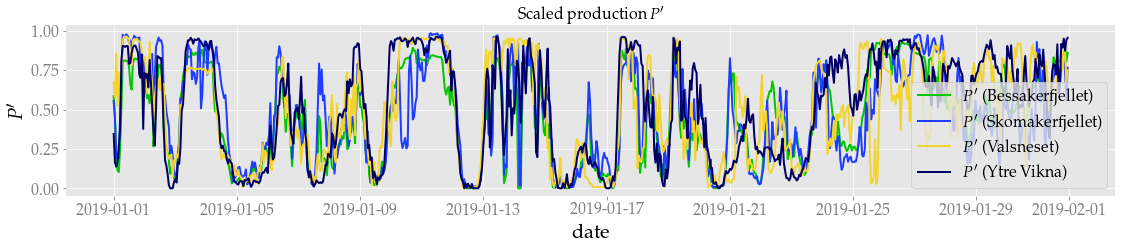

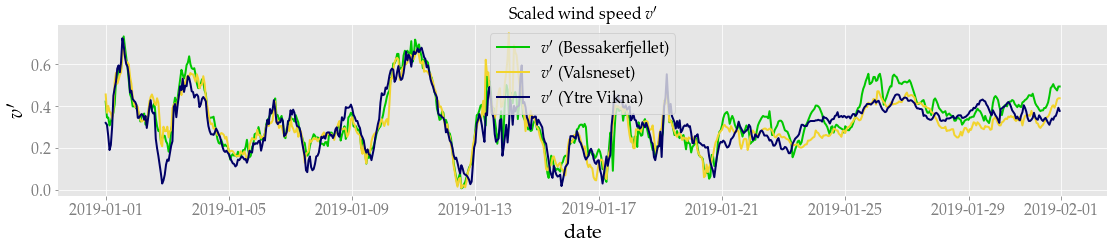

In [118]:
def plot_production_wind_speed(wind, prod):
    start = '2019-01-01 00:00:00'
    stop = '2019-01-31 23:00:00'
    plt.figure(figsize=(16,4))
    for col in prod.columns:
        plt.plot(wind.loc[start:stop].index, prod[col].loc[start:stop].values, label=col)
            
    plt.legend()
    plt.title(r"Scaled production $P'$")
    plt.ylabel(r"$P'$")
    plt.xlabel('date')
    plt.tight_layout()
    plt.savefig('prod_comp.png')
    plt.show()

    plt.figure(figsize=(16,4))
    for i, col in enumerate(wind.columns):
        if i==3: break
        if 'Vals' in col:
            plt.plot(wind.loc[start:stop].index, wind[col].loc[start:stop].values, label=col, 
                     color='#F2D42E')
        elif 'Ytre' in col:
            plt.plot(wind.loc[start:stop].index, wind[col].loc[start:stop].values, label=col, 
                     color='#000066')
        else:
            plt.plot(wind.loc[start:stop].index, wind[col].loc[start:stop].values, label=col)
    plt.legend()
    plt.title(r"Scaled wind speed $v'$")
    plt.ylabel(r"$v'$")
    plt.xlabel('date')
    plt.tight_layout()
    plt.savefig('speed_comp.png')
    plt.show()

plot_production_wind_speed(wind_normal, prod_normal)

## Correlation of production at the different parks for all time points

In [6]:
#prod = max_min_df_scaler(prod)

,production_bess,production_skom,production_vals,production_yvik
time,,,,
2006-01-01 00:00:00,NaN,NaN,NaN,NaN
2006-01-01 01:00:00,NaN,NaN,NaN,NaN
2006-01-01 02:00:00,NaN,NaN,NaN,NaN
2006-01-01 03:00:00,NaN,NaN,NaN,NaN
2006-01-01 04:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-05-27 19:00:00,0.076098,0.094194,0.235062,0.179191
2021-05-27 20:00:00,0.043787,0.070776,0.289942,0.192090
2021-05-27 21:00:00,0.045520,0.051906,0.259857,0.262937


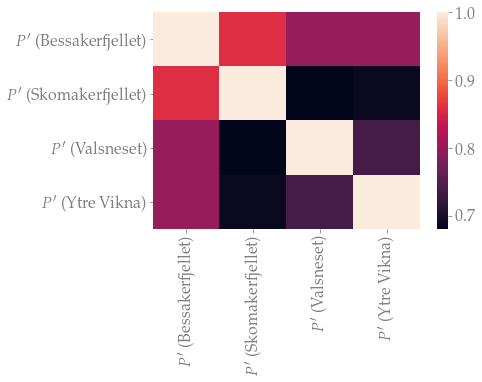

In [63]:
sns.heatmap(prod_normal.corr())
plt.show()

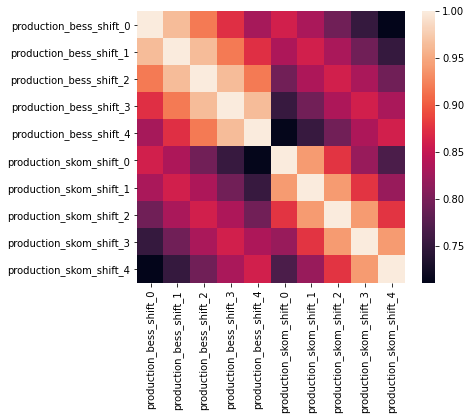

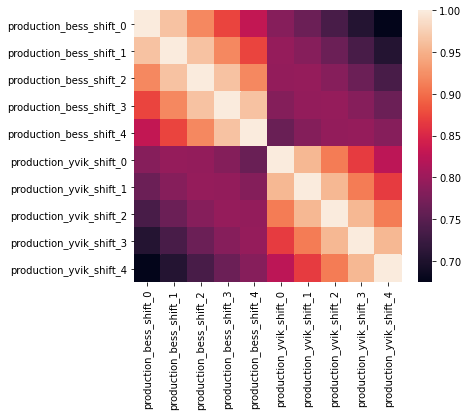

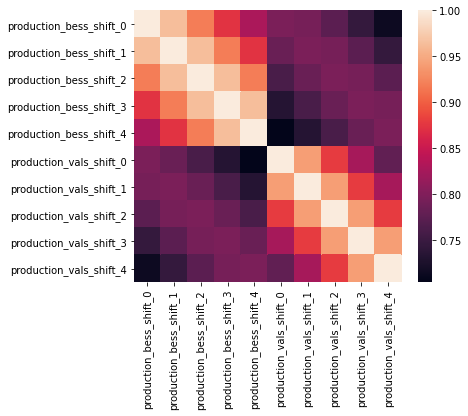

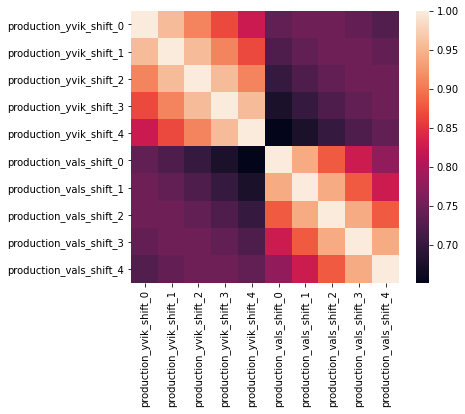

In [8]:
heatmaps_park_productions_lags(prod, lag_limit=5)

- Production at the different parks are very correlated
- Production at Yvik in lags -1, -2 is correlated to 0 at the other parks
- Production at Vals in lags 0, 1 is correlated to 0 at Bess and Skom
- Production at Vals in lags 1, 2 is correlated to 0 at Yvik

This means that Yvik "knows" that there is going to be a rise in production at Bess and Skom 1-2 hours in advance, and that the production at Bess and Skom gives the same information about Vals 0-1 hours before.

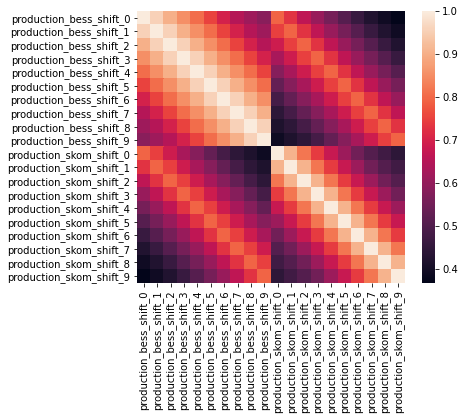

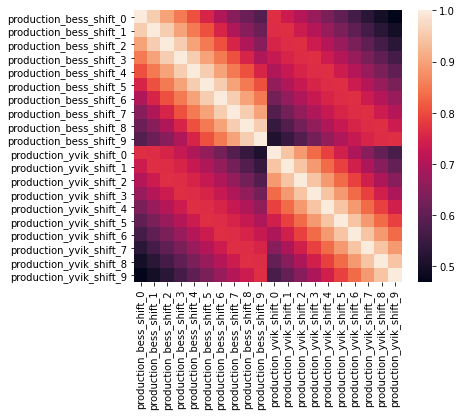

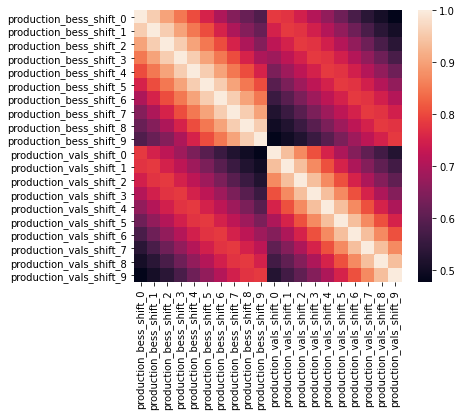

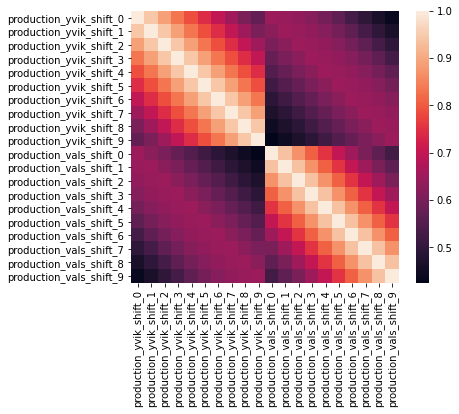

In [9]:
park_for_direction_filter = 'vals'
direction = 'SW'
plot_correlations_given_direction(direction, park_for_direction_filter)

## How often is the wind direction more or less the same at all parks?

In [99]:
df_sin = get_columns(wind, 'sin')
df_cos = get_columns(wind, 'cos')

In [101]:
df_sin.columns = [r"$\cos{\theta}$ (Bessakerfjellet)", r"$\cos{\theta}$ (Valsneset)", r"$\cos{\theta}$ (Ytre Vikna)"]
df_cos.columns = [r'$\sin{\theta}$ (Bessakerfjellet)', r'$\sin{\theta}$ (Valsneset)', r'$\sin{\theta}$ (Ytre Vikna)']

In [102]:
df_sin.corr()

,$\cos{\theta}$ (Bessakerfjellet),$\cos{\theta}$ (Valsneset),$\cos{\theta}$ (Ytre Vikna)
$\cos{\theta}$ (Bessakerfjellet),1.000000,0.912840,0.882517
$\cos{\theta}$ (Valsneset),0.912840,1.000000,0.779908
$\cos{\theta}$ (Ytre Vikna),0.882517,0.779908,1.000000


In [103]:
df_cos.corr()

,$\sin{\theta}$ (Bessakerfjellet),$\sin{\theta}$ (Valsneset),$\sin{\theta}$ (Ytre Vikna)
$\sin{\theta}$ (Bessakerfjellet),1.000000,0.926046,0.895712
$\sin{\theta}$ (Valsneset),0.926046,1.000000,0.834961
$\sin{\theta}$ (Ytre Vikna),0.895712,0.834961,1.000000


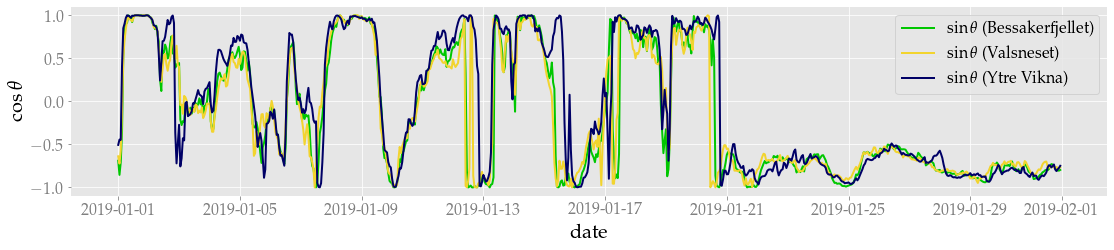

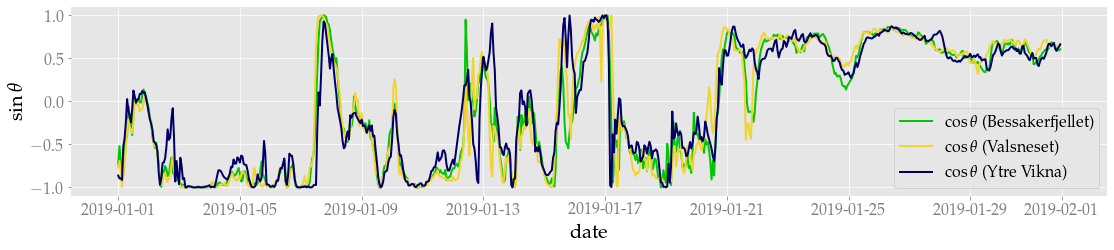

In [115]:
def plot_direction_comparison(df_cos, df_sin):
    start = '2019-01-01 00:00:00'
    stop = '2019-01-31 23:00:00'
    plt.figure(figsize=(16,4))
    for col in df_cos.columns:
        if 'Vals' in col:
            plt.plot(df_cos[col].loc[start:stop].index, df_cos[col].loc[start:stop].values, label=col, 
                     color='#F2D42E')
        elif 'Ytre' in col:
            plt.plot(df_cos[col].loc[start:stop].index, df_cos[col].loc[start:stop].values, label=col, 
                     color='#000066')
        else:
            plt.plot(df_cos[col].loc[start:stop].index, df_cos[col].loc[start:stop].values, label=col)
    plt.ylabel(r'$\cos{\theta}$')
    plt.xlabel('date')
    plt.legend()
    plt.tight_layout()
    plt.savefig('dir_comp_cos.png')
    plt.show()

    plt.figure(figsize=(16,4))
    for col in df_sin.columns:
        if 'Vals' in col:
            plt.plot(df_sin[col].loc[start:stop].index, df_sin[col].loc[start:stop].values, label=col, 
                     color='#F2D42E')
        elif 'Ytre' in col:
            plt.plot(df_sin[col].loc[start:stop].index, df_sin[col].loc[start:stop].values, label=col, 
                     color='#000066')
        else:
            plt.plot(df_sin[col].loc[start:stop].index, df_sin[col].loc[start:stop].values, label=col)
    plt.ylabel(r'$\sin{\theta}$')
    plt.xlabel('date')
    plt.legend()
    plt.tight_layout()
    plt.savefig('dir_comp_sin.png')
    plt.show()

plot_direction_comparison(df_cos, df_sin)

In [119]:
# given month, plot sin and cos values and correlation
month = 1
#plot_direction_relations(month)

In [121]:
park_names = {
    'bess': 'Bessakerfjellet', 
    'skom': 'Skomakerfjellet', 
    'vals': 'Valsneset', 
    'yvik': 'Ytre Vikna'
}

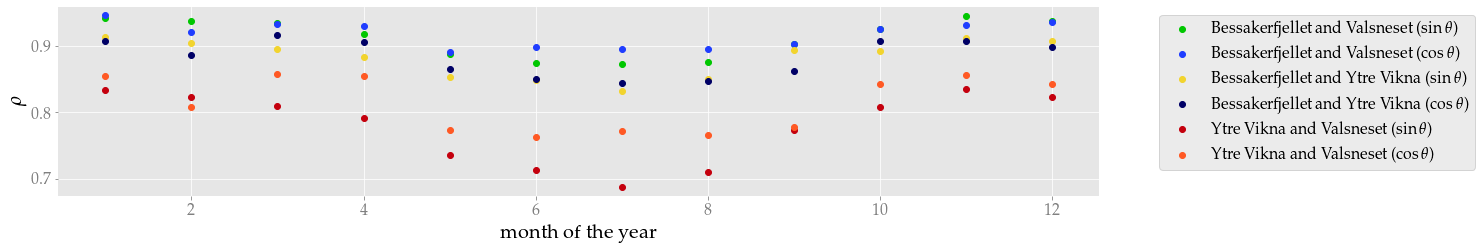

In [126]:
def correlation_through_year(df_sin, df_cos):
    cos_corrs = {'bess-vals': [], 'bess-yvik': [], 'yvik-vals': []}
    sin_corrs = {'bess-vals': [], 'bess-yvik': [], 'yvik-vals': []}

    for j in [(0,1,'bess-vals'),(0,2,'bess-yvik'),(1,2,'yvik-vals')]:
        for month in range(1,13):
            cos_corrs[j[2]].append(df_cos[df_cos.index.month == month].corr().values[j[0],j[1]])
            sin_corrs[j[2]].append(df_sin[df_sin.index.month == month].corr().values[j[0],j[1]])

    plt.figure(figsize=(16,4))
    for key, value in sin_corrs.items():
        name = park_names[key.split('-')[0]] + ' and ' + park_names[key.split('-')[1]]
        
        plt.scatter(np.arange(1, len(value)+1), value, label=name+r' ($\sin{\theta}$)')
        plt.scatter(np.arange(1, len(value)+1), cos_corrs[key], label=name+r' ($\cos{\theta}$)')
    plt.xlabel('month of the year')
    plt.ylabel(r'$\rho$')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('dir_corr_through_year.png')
    plt.show()

correlation_through_year(df_sin, df_cos)